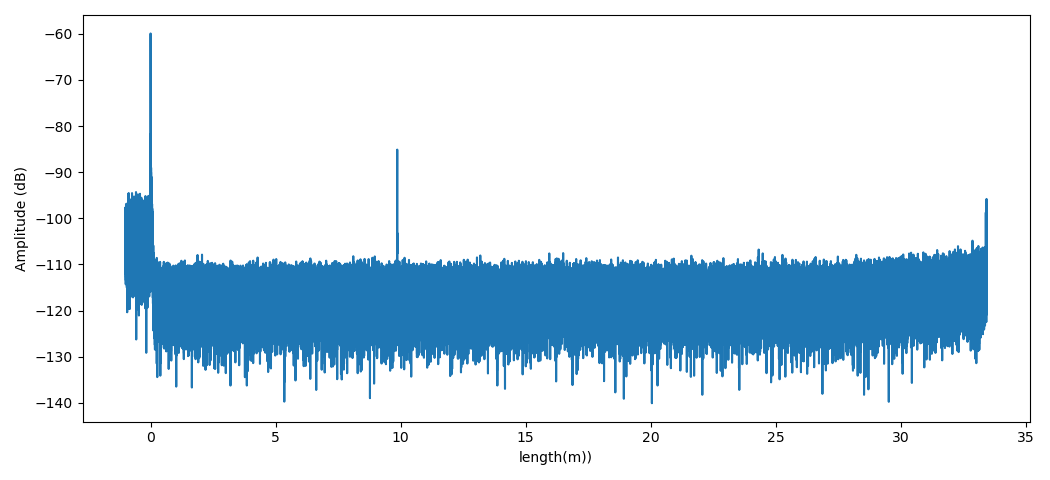

In [32]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.lines import lineStyles
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import ipywidgets as widgets
import os

#pd.options.plotting.backend = "plotly"

directory = r'C:\Users\LABUSERS\Desktop\phase measurement quadrature\check length of fiber'

filename = '10m_1_test1_Upper.txt'

df = pd.read_csv(os.path.join(directory, filename), delimiter='\t', skiprows=11, header=1)

col_time = df['Time (ns)']
col_amp = df['Amplitude']
ng=1.5
col_length=(col_time*10**-9)*299792458/ng
col_amp_diff = col_amp.rolling(10).mean().diff()**4

#plt.figure(figsize=(10.5,4.8))
fig, ax = plt.subplots(figsize=(10.5,4.8))
plt.plot(col_length, col_amp)
plt.xlabel('length(m)')
plt.ylabel('Amplitude (dB)')
plt.tight_layout()



In [30]:
current_range = (40.430287724261206, 49.501651936926024)

tmin = np.where(col_time >= current_range[0])[0][0]
tmax = np.where(col_time >= current_range[1])[0][0]
plot_range = [299792458*col_time[tmin]*1e-9/ng, 299792458*col_time[tmax]*1e-9/ng]
print(plot_range)


[8.080669149154474, 9.893494196488936]


In [ ]:
peaks, _ = find_peaks(col_amp1, height=-90, distance=2)
print(peaks)


In [21]:
# Plot in length domain and compute loss
#current_range = ax.get_xlim()

col_time1 = col_time[tmin:tmax]
col_amp1 = col_amp[tmin:tmax]
col_amp_diff1 = col_amp_diff[tmin:tmax]

# Find peaks within plot range (keep only first and last peaks)
peaks, _ = find_peaks(col_amp1, height=-90, distance=2)
print(peaks)
peaks = [peaks[0], peaks[-1]]

# Calculate group index based on a known distance between the two peaks
#vg = physical_length / (cd4ol_time[peaks[1]] - col_time[peaks[0]]) / 1e-9
#ng = 299792459/vg
#print('Group Index:', ng, '\n')

col_dist = 299792458*col_time*1e-9 / ng

# Plot parameters
plot_range = [299792458*col_time[tmin]*1e-9/ng, 299792458*col_time[tmax]*1e-9/ng]

# Plot
fig = plt.figure(directory.split('/')[-2] + ' - ' + filename[:-4])#dpi=200)
plt.plot(col_dist, col_amp)
plt.xlabel('Position [m]')
plt.ylabel('Amplitude [dB]')
plt.xlim(plot_range)
plt.ylim([-110, 0])

# Mark the input & output facet peaks
plt.plot(col_dist[peaks+tmin], col_amp[peaks+tmin], 'rx')

# Define window for curve fit
dist1 = np.where(col_dist >= col_dist[peaks[0]+tmin]+0.1)[0][0]
dist2 = np.where(col_dist >= col_dist[peaks[1]+tmin]-0.1)[0][0]

# Linear least-squares regression
from scipy.stats import linregress
a = linregress(col_dist[dist1:dist2].to_numpy(), col_amp[dist1:dist2].to_numpy())
print(a, '\n')

# Bootstrap from linear regression
def my_statistic(x, y):
    return linregress(x, y).slope
from scipy.stats import bootstrap
a = bootstrap((col_dist[dist1:dist2].to_numpy(), col_amp[dist1:dist2].to_numpy()), my_statistic, vectorized=False, paired=True)
print(a)
print(np.mean([a.confidence_interval.low, a.confidence_interval.high]), '\n')
plt.text((col_dist[dist1]+col_dist[dist2])/2, -18, 
            r"$\bf{95\%\ Confidence\ Interval}$" +
            f': ({a.confidence_interval.low/2:0.3f}, {a.confidence_interval.high/2:0.3f})' +
            f'\n\nα={np.mean([a.confidence_interval.low, a.confidence_interval.high])/2:0.3f} dB/m',
            horizontalalignment='center')

# Perform curve fit and output result
def fit_func(x, m, b):
    return m*x - b
popt, pcov = curve_fit(fit_func, col_dist[dist1:dist2], col_amp[dist1:dist2])
p = plt.plot(col_dist[dist1:dist2], fit_func(col_dist[dist1:dist2], *popt))
plt.vlines(col_dist[dist1], fit_func(col_dist[dist1], *popt)-10, fit_func(col_dist[dist1], *popt)+10, linestyle='solid', color=p[0].get_color())
plt.vlines(col_dist[dist2], fit_func(col_dist[dist2], *popt)-10, fit_func(col_dist[dist2], *popt)+10, linestyle='solid', color=p[0].get_color())
print(f'Curve fit between {col_dist[dist1]} and {col_dist[dist2]}:\n    {popt[0]}x - {popt[1]}')

[5802 5810]


NameError: name 'ng' is not defined